# COM4509/6509 MLAI - Assignment Part 2 Brief

## Deadline: Friday, December 3, 2021 at 15:00 hrs

## Scope: Sessions 6 to 8

## Number of marks available for Part 2: 25

### Please READ the whole assignment first, before starting to work on it.

### How and what to submit

1. A Jupyter Notebook with the code in all the cells executed, outputs displayed, and code
documented.

2. Name your Notebook as COM4509-6509_Assignment_Part2_Username_XXXXXX.ipynb where XXXXXX is your username such as abc18de.

3. Upload a .zip file to Blackboard before the deadline that contains two Jupyter Notebooks, one for Part 1 and one for Part 2 (COM4509-6509_Assignment_Part1_Username_XXXXXX.ipynb and COM4509-6509_Assignment_Part2_Username_XXXXXX.ipynb)

4. NO DATA UPLOAD: Please do not upload the data files used in this Notebook. We have a copy already. Instead, please use a relative file path in your code (data files under folder ‘data’), as in the lab notebook so that we can run your code smoothly when needed. So ‘./data/’, instead of ‘/User/username/myfiles/mlai/assignment1/’

### Assessment Criteria

1) Being able to build complete, reproducible machine learning pipelines from loading data to evaluating prediction performance.

2) Being able to design different machine learning models to compare/optimise prediction performance.

3) Being able to perform exploratory data analysis to gain insights.

## A. Reproducibility & readability

In [240]:
import sys
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
from torch.autograd import Variable
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import medmnist
from medmnist import INFO, Evaluator
%matplotlib inline


# Set a random seed for reproducibility
np.random.seed(210169508)
torch.manual_seed(210169508)

## B. Logistic Regression on BreastMNIST [9 marks]

The first version of the MedMNIST, published in ISBI21 (2010.14925.pdf (arxiv.org)). As taken from the paper: BreastMNIST is based on a dataset of 780 breast ultrasound images. It is categorized into 3 classes: normal, benign and malignant originally but in BreastMNIST, the task is simplified into binary classification by combining normal and benign as positive, and classifying them against malignant as negative. The source dataset with a ratio of 7 : 1 : 2 into training, validation and test set. The source images of 1 × 500 × 500 are resized into 1 × 28 × 28.

We aim to train a L2-regularised logistic regression model to classify the two classes in BreastMNIST using the standard train/validation/test split with decent performance, i.e. much better than the chance level at worst.

### B1 Data loading and inspection [3 mark]

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 20 images, from the training set. Display at least ten images for each class from the validation set, and display at least ten images for each class from the test set.


In [2]:
# ------ My answer of B1 ------ #
data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 10 # Set epochs
BATCH_SIZE = 64 # Set batch
lr = 0.001 # Set learning rate

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels'] # 1 channel
n_classes = len(info['label']) # 2 classes
print("The type of this dataset is:", task)
print("It has ", n_channels, " channel")
print("The label of the dataset is: ", info['label'])

DataClass = getattr(medmnist, info['python_class'])

# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data
train_dataset = DataClass(root='./data', split='train', transform=data_transform, download=download) # 546
val_dataset = DataClass(root='./data', split='val', transform=data_transform, download=download)     # 78
test_dataset = DataClass(root='./data', split='test', transform=data_transform, download=download)   # 156

# Encapsulate data into dataloader form
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)
train_loader_at_eval = DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# visualization
def class_count(dataset):
    normal_benign_count = 0
    malignant_count = 0

    for i in dataset.labels:
        if i[0] == 1:
            normal_benign_count += 1
            
        elif i[0] == 0:
            malignant_count += 1
    # print(dataset.imgs.shape) (546, 28, 28) (78, 28, 28) (156, 28, 28)
    print("There are", normal_benign_count, "normal or benign imgs and", malignant_count, "malignant imgs in the", dataset.split, "dataset")

class_count(train_dataset)      
class_count(val_dataset)
class_count(test_dataset)

The type of this dataset is: binary-class
It has  1  channel
The label of the dataset is:  {'0': 'malignant', '1': 'normal, benign'}
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
Using downloaded and verified file: ./data/breastmnist.npz
There are 399 normal or benign imgs and 147 malignant imgs in the train dataset
There are 57 normal or benign imgs and 21 malignant imgs in the val dataset
There are 114 normal or benign imgs and 42 malignant imgs in the test dataset


# ------ Below we display two classes images from the training set ------ #
There are 19 malignant images in this batch.


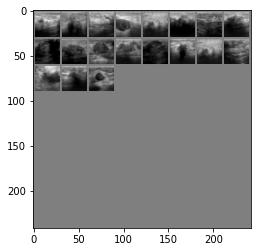

There are 45 normal or benign images in this batch.


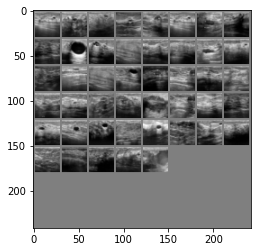

# ----- Below we display two classes images from the validation set ----- #
There are 15 malignant images in this batch.


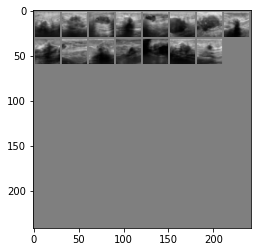

There are 49 normal or benign images in this batch.


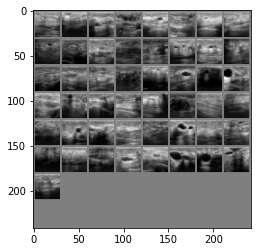

# -------- Below we display two classes images from the test set -------- #
There are 20 malignant images in this batch.


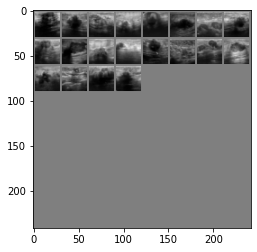

There are 44 normal or benign images in this batch.


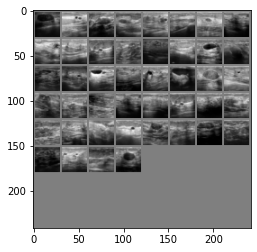

End of question B1 [3 marks].


In [3]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

def display_img(dataloader):
    dataiter = iter(dataloader) # Get some random images
    images, labels = dataiter.next() # Get one batch (64 here)

    empty_0 = torch.zeros(images.shape) # Set up an empty torch to store imgs for class 0
    empty_1 = torch.zeros(images.shape) # Set up an empty torch to store imgs for class 1

    nor_ben_index = -1
    mali_index = -1
    index = -1

    for i in labels:
        index += 1
        if i[0] == 0:
            mali_index += 1
            empty_0[mali_index] = images[index] # Store class 0 images in empty_0
        
        elif i[0] == 1:
            nor_ben_index += 1
            empty_1[nor_ben_index] = images[index] # Store class 1 images in empty_1

    print("There are", mali_index+1, "malignant images in this batch.")
    imshow(torchvision.utils.make_grid(empty_0))
    print("There are", nor_ben_index+1, "normal or benign images in this batch.")
    imshow(torchvision.utils.make_grid(empty_1))

print("# ------ Below we display two classes images from the training set ------ #")
display_img(train_loader)
print("# ----- Below we display two classes images from the validation set ----- #")
display_img(val_loader)
print("# -------- Below we display two classes images from the test set -------- #")
display_img(test_loader)
print("End of question B1 [3 marks].")

### B2 Logistic regression [4 marks]

Keep a record of the three metrics M1 to M3 below for the two models below:
* M1) Training accuracy: the prediction accuracy of a trained model on the training dataset.
* M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset.
* M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.

**a.** Using the built-in logistic regression functions in scikit-learn, train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3 **[2 marks]**

**b.** Using PyTorch (see Question 5 of Lab 6), train a logistic regression model with L2 regularisation on the training set, use the validation set to choose a good regularisation parameter (a hyperparameter) from at least three choices, and test the chosen model on the test set. Report the three metrics M1 to M3 **[2 marks]**

In [4]:
# ------ My answer of B2a ------ #
X_train = np.array([img.numpy().flatten() for img, label in train_dataset]) # 546 x 784
y_train = np.array([label for img, label in train_dataset]).ravel()         # (546,)

X_val = np.array([img.numpy().flatten() for img, label in val_dataset])     # 78 x 784
y_val = np.array([label for img, label in val_dataset]).ravel()             # (78,)

X_test = np.array([img.numpy().flatten() for img, label in test_dataset])   # 156 x 784
y_test = np.array([label for img, label in test_dataset]).ravel()           # (156,)

names = ['C10','C5','C1','C0.5','C0.1','wd0.1','wd0.01','wd0.001','wd0.0001']
M1 = []
M2 = []
M3 = []

M1a = 0
M2a = 0
M3a = 0

def metrics_report(reg_strength):
    
    # Regularization strength C is a hyperparameter, I will change it for at least 3 times
    my_model = LogisticRegression(penalty='l2', C=reg_strength, solver='lbfgs', max_iter = 800)
    my_model.fit(X_train, y_train)
    
    train_pred = my_model.predict(X_train)
    val_pred = my_model.predict(X_val)
    test_pred = my_model.predict(X_test)
    
    M1a = accuracy_score(y_train, train_pred)
    M2a = accuracy_score(y_val, val_pred)
    M3a = accuracy_score(y_test, test_pred)
    
    M1.append(100 * M1a)
    M2.append(100 * M2a)
    M3.append(100 * M3a)

    return {
        'M1 Training accuracy': M1a,
        'M2 Validation accuracy': M2a,
        'M3 Testing accuracy': M3a,
    }

# Firstly, set the regularization strength C = 10.0
print("regularization strength C = 10.0")
metrics_report(reg_strength=10.0)

regularization strength C = 10.0


{'M1 Training accuracy': 0.9981684981684982,
 'M2 Validation accuracy': 0.8589743589743589,
 'M3 Testing accuracy': 0.7564102564102564}

In [5]:
print("regularization strength C = 5")
metrics_report(reg_strength=5)

regularization strength C = 5


{'M1 Training accuracy': 0.9981684981684982,
 'M2 Validation accuracy': 0.8333333333333334,
 'M3 Testing accuracy': 0.7628205128205128}

In [6]:
print("regularization strength C = 1.0")
metrics_report(reg_strength=1.0)

regularization strength C = 1.0


{'M1 Training accuracy': 0.9487179487179487,
 'M2 Validation accuracy': 0.8461538461538461,
 'M3 Testing accuracy': 0.8205128205128205}

In [7]:
print("regularization strength C = 0.5")
metrics_report(reg_strength=0.5)

regularization strength C = 0.5


{'M1 Training accuracy': 0.9120879120879121,
 'M2 Validation accuracy': 0.8461538461538461,
 'M3 Testing accuracy': 0.7948717948717948}

In [8]:
print("regularization strength C = 0.1")
metrics_report(reg_strength=0.1)

regularization strength C = 0.1


{'M1 Training accuracy': 0.8571428571428571,
 'M2 Validation accuracy': 0.8333333333333334,
 'M3 Testing accuracy': 0.7948717948717948}

In [9]:
# ------ My answer of B2b ------ #
NUM_EPOCHS = 10                  # Set epochs
BATCH_SIZE = 64                  # Set batch
lr = 0.001                       # Set learning rate
n_classes = len(info['label'])   # 2 classes {0, 1}
input_dim = 784                  # 28*28


M1b = 0
M2b = 0
M3b = 0

class LogisticRegression(nn.Module):
    
    # input_dim = 28*28, n_classes = 2
    def __init__(self, input_dim, n_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, n_classes)
        
    def forward(self, x):    
        y_pred = torch.sigmoid(self.linear(x))
        return y_pred
    
LR = LogisticRegression(input_dim, n_classes)
print(LR)

def metrics_report_2(model, optimizer):
    criterion = nn.CrossEntropyLoss()
    
    for epoch in range(NUM_EPOCHS):
        for i, (images, labels) in enumerate(train_loader):
            images = Variable(images.view(-1, input_dim)) # torch.Size([64, 784])            
            labels = Variable(labels)                     # torch.Size([64, 1])
            labels = torch.squeeze(labels)                # torch.Size([64])
                           
            optimizer.zero_grad()
            outputs = model(images)                       # torch.Size([64, 2])
                        
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
    

    # M1 Training accuracy = M1b
    correct_train = 0
    total_train = 0
    for images, labels in train_loader_at_eval:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)        
        
        correct_train += (predicted == labels).sum()
        total_train += labels.size(0)
                
    M1b = correct_train / total_train
    print("Trained images:", int(total_train), "Predicted correct:", int(correct_train), "M1:", float(M1b))

    
    # M2 Training accuracy = M2b
    correct_val = 0
    total_val = 0
    for images, labels in val_loader:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)        
        
        correct_val += (predicted == labels).sum()
        total_val += labels.size(0)
                
    M2b = correct_val / total_val
    print("Validated images:", int(total_val), "Predicted correct:", int(correct_val), "M2:", float(M2b))
    

    # M3 Testing accuracy = M3b
    correct_test = 0
    total_test = 0
    for images, labels in test_loader:
        images = Variable(images.view(-1, input_dim))
        labels = torch.squeeze(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        correct_test += (predicted == labels).sum()
        total_test += labels.size(0)
    
    M3b = correct_test / total_test
    print("Test images:", int(total_test), "Predicted correct:", int(correct_test), "M3:", float(M3b))
    
    M1.append(100 * M1b)
    M2.append(100 * M2b)
    M3.append(100 * M3b)

    return(M1b, M2b, M3b)

print("Set L2 parameters weight_decay = 0.1")
optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=lr, weight_decay = 0.1)
(M1b, M2b, M3b) = metrics_report_2(LR, optimizer_L2)

LogisticRegression(
  (linear): Linear(in_features=784, out_features=2, bias=True)
)
Set L2 parameters weight_decay = 0.1
Trained images: 546 Predicted correct: 394 M1: 0.721611738204956
Validated images: 78 Predicted correct: 56 M2: 0.7179487347602844
Test images: 156 Predicted correct: 110 M3: 0.7051281929016113


In [10]:
print("Set L2 parameters weight_decay = 0.01")
optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=lr, weight_decay = 0.01)
(M1b, M2b, M3b) = metrics_report_2(LR, optimizer_L2)

Set L2 parameters weight_decay = 0.01
Trained images: 546 Predicted correct: 397 M1: 0.7271062135696411
Validated images: 78 Predicted correct: 57 M2: 0.7307692170143127
Test images: 156 Predicted correct: 112 M3: 0.7179487347602844


In [11]:
print("Set L2 parameters weight_decay = 0.001")
optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=lr, weight_decay = 0.001)
(M1b, M2b, M3b) = metrics_report_2(LR, optimizer_L2)

Set L2 parameters weight_decay = 0.001
Trained images: 546 Predicted correct: 397 M1: 0.7271062135696411
Validated images: 78 Predicted correct: 57 M2: 0.7307692170143127
Test images: 156 Predicted correct: 114 M3: 0.7307692170143127


In [12]:
print("Set L2 parameters weight_decay = 0.0001")
optimizer_L2 = torch.optim.SGD(LR.parameters(), lr=lr, weight_decay = 0.0001)
(M1b, M2b, M3b) = metrics_report_2(LR, optimizer_L2)

Set L2 parameters weight_decay = 0.0001
Trained images: 546 Predicted correct: 397 M1: 0.7271062135696411
Validated images: 78 Predicted correct: 57 M2: 0.7307692170143127
Test images: 156 Predicted correct: 114 M3: 0.7307692170143127


### B3 Performance comparison (2 marks)

**a.** Summarise each of the three metrics from the two models in B2 using one or more bar graphs. **[1 mark]**

**b.** Describe at least two observations interesting to you. **[1 mark]**

(60.0, 100.0)

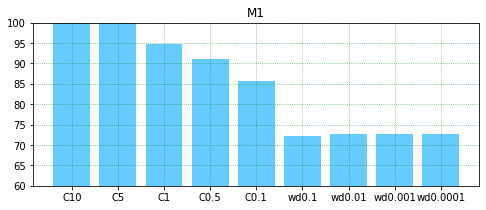

In [13]:
# ------ My answer of B3a ------ #
plt.figure(figsize = (8, 3))
plt.title('M1')
plt.bar(np.arange(len(M1)), M1, color = "#66ccff")
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M1)), names)
plt.ylim([60, 100])

(60.0, 100.0)

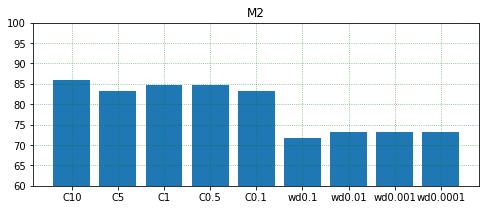

In [14]:
plt.figure(figsize = (8, 3))
plt.title('M2')
plt.bar(np.arange(len(M2)), M2)
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M2)), names)
plt.ylim([60, 100])

(60.0, 100.0)

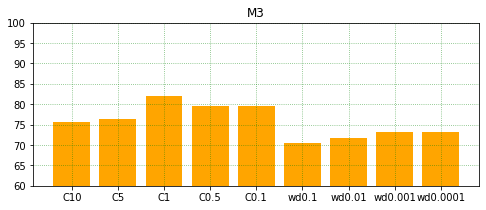

In [15]:
plt.figure(figsize = (8, 3))
plt.title('M3')
plt.bar(np.arange(len(M3)), M3, color = "orange")
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M3)), names)
plt.ylim([60, 100])

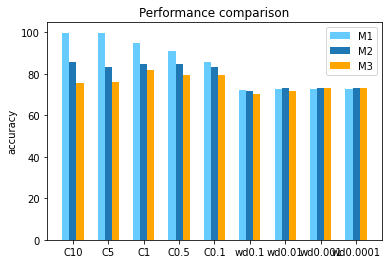

In [16]:
x = np.arange(len(names))  # the label locations
width = 0.2                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, M1, width, label='M1', color="#66ccff")
rects2 = ax.bar(x, M2, width, label='M2')
rects3 = ax.bar(x + width, M3, width, label='M3', color="orange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.legend()

In [17]:
print("# ------ My answer of B3b ------ #")

# ------ My answer of B3b ------ #


For question B2a using scikit-learn:
* I choose more than 10 Regularization Strength value to observe, and choose 5 values as specific examples (e.g. 10, 5, 1, 0.5, 0.1).
* As the value of c decreases, M1 Training accuracy tends to decrease, from 0.998 to 0.857. That is smaller C values specify stronger regularization.
* As the value of c decreases, M2 Validation accuracy behaves steadily, fluctuating between 0.833 and 0.859.
* M3 has the highest accuracy and performs best when c takes the default value (i.e. is 1). It may be that scikit-learn is better optimised for default values.

For question B2b using pytorch:
* I choose 4 different `weight_decay` values as parameter in optimizer (e.g. 1e-1 1e-2 1e-3 1e-4).
* Overall the model don't perform as well on pytorch as they do on sk-learn.
* To my surprise, the accuracy is not very different in the three data sets.

## C. Convolutional Neural Networks on OCTMNIST [8 marks]

OCTMNIST is based on a prior dataset of 109,309 valid optical coherence tomography (OCT) images for retinal diseases, with 4 different types, leading to a multi-class classification task. The source training set is split with a ratio of 9 : 1 into training and validation sets, and uses its source validation set as the test set. The source images are single channel, and their sizes are (384−1, 536)×(277−512), which are center-cropped and resized to 1 × 28 × 28.

### C1 Data loading and inspection [2 mark]

Follow instructions at https://github.com/MedMNIST/MedMNIST to download and load the data. Display at least ten images for each class, i.e. at least 40 images, from the training set.

In [18]:
# ------ My answer of C1 ------ #
data_flag_C = 'octmnist'
download = True

NUM_EPOCHS_C = 5 # Set epochs
BATCH_SIZE_C = 64 # Set batch
lr_C = 0.005 # Set learning rate

info_C = INFO[data_flag_C]
task_C = info['task']
n_channels_C = info['n_channels']   # 1 channel
n_classes_C = len(info['label'])    # 4 classes
print("The type of this dataset is:", task_C)
print("It has ", n_channels_C, " channel")
print("The label of the dataset is: ", info_C['label'])

DataClass = getattr(medmnist, info_C['python_class'])

# Preprocessing
data_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[.5], std=[.5])
])

# Load the data
train_dataset_C = DataClass(root='./data', split='train', transform=data_transform, download=download) # 
val_dataset_C = DataClass(root='./data', split='val', transform=data_transform, download=download)     # 
test_dataset_C = DataClass(root='./data', split='test', transform=data_transform, download=download)   # 

# Encapsulate data into dataloader form
train_loader_C = DataLoader(dataset=train_dataset_C, batch_size=BATCH_SIZE_C, shuffle=True)
val_loader_C = DataLoader(dataset=val_dataset_C, batch_size=BATCH_SIZE_C, shuffle=True)
test_loader_C = DataLoader(dataset=test_dataset_C, batch_size=BATCH_SIZE_C, shuffle=False)
train_loader_at_eval_C = DataLoader(dataset=train_dataset_C, batch_size=2*BATCH_SIZE_C, shuffle=False)


def class_count(dataset):
    choroidal_neo = 0
    diabetic_mac = 0
    drusen = 0
    normal = 0
    
    for i in dataset.labels:
        if i[0] == 0:
            choroidal_neo += 1
            
        elif i[0] == 1:
            diabetic_mac += 1
        
        elif i[0] == 2:
            drusen += 1
        
        elif i[0] == 3:
            normal += 1
            
    # print(dataset.imgs.shape) # (97477, 28, 28) (10832, 28, 28) (1000, 28, 28)
    print("0:", choroidal_neo, "1:", diabetic_mac, "2:", drusen, "3:", normal, "in the", dataset.split, "dataset")

class_count(train_dataset_C)      
class_count(val_dataset_C)
class_count(test_dataset_C)

The type of this dataset is: binary-class
It has  1  channel
The label of the dataset is:  {'0': 'choroidal neovascularization', '1': 'diabetic macular edema', '2': 'drusen', '3': 'normal'}
Using downloaded and verified file: ./data/octmnist.npz
Using downloaded and verified file: ./data/octmnist.npz
Using downloaded and verified file: ./data/octmnist.npz
0: 33484 1: 10213 2: 7754 3: 46026 in the train dataset
0: 3721 1: 1135 2: 862 3: 5114 in the val dataset
0: 250 1: 250 2: 250 3: 250 in the test dataset


choroidal neovascularization


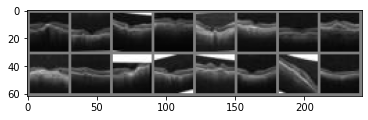

diabetic macular edema


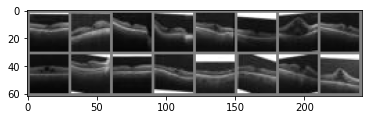

drusen


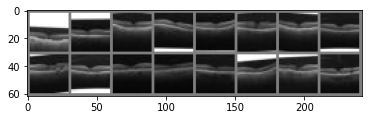

normal


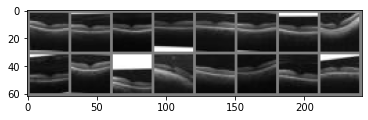

# ------ End of question C1 ------ #


In [19]:
# visualization
classes = ('choroidal neovascularization', 'diabetic macular edema', 'drusen', 'normal')
outputs = [[] for i in range(len(classes))]

for image, labels in train_loader_C:
    for i in range(BATCH_SIZE_C):
        outputs[labels[i]].append(image[i])
   
    if all(len(x) >= 16 for x in outputs): # lists 16 values
        break
        
for idx, show_output in enumerate(outputs):
    print (classes[idx])
    imshow(torchvision.utils.make_grid(show_output[:16]))
print("# ------ End of question C1 ------ #")

### C2 Convolutional neural networks [4 marks]

Keep a record of the four metrics M1 to M4 below for the two models below:
* M1) Training accuracy: the prediction accuracy of a trained model on the training dataset. 
* M2) Validation accuracy: the prediction accuracy of a trained model on the validation dataset. 
* M3) Testing accuracy: the prediction accuracy of a trained model on the test dataset.
* M4) Training time: the time taken to train the model (i.e. to learn/estimate the learnable parameters) on the training dataset.

This question asks you to design convolutional neural networks (CNNs). Only the number of convolutional (Conv) layers and the number of fully connected (FC) layers will be specified below. You are free to design other aspects of the network. For example, you can use other types of operation (e.g. padding), layers (e.g. pooling, or preprocessing (e.g. augmentation), and you choose the number of units/neurons in each layer. Likewise, you may choose the number of epochs and many other settings according to your accessible computational power.

**a.** Design a CNN with two Conv layers and two FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**

**b.** Design a CNN with three Conv layers and three FC layers. Train the model on the training set, use the validation set to choose the best design among at least three different choices, and test the chosen model on the test set. Report the four metrics M1 to M4 **[2 marks]**

In [20]:
# ------ My answer of C2a ------ #
# CNN with 2 Convs and 2 FC layers

class CNN1(nn.Module):
    def __init__(self, kernel_size1, kernel_size2):
        super(CNN1, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size1)     # 1 input channels; 6 output channels;  kernel size
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, kernel_size2)
        self.fc1 = nn.Linear(16 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 4 * 4)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

criterion = nn.CrossEntropyLoss()

In [21]:
names_C = ['aks_55','aks_54','aks_44','bks_555','bks_455','bks_445']
M1_C = []
M2_C = []
M3_C = []
M4_C = []

def metrics_report_3a(model):
    start = time.time()
    for epoch in range(NUM_EPOCHS_C):

        running_loss = 0.0
        for i, data in enumerate(train_loader_C, 0):
            
            inputs, labels = data
            labels = torch.squeeze(labels)
        
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 500 == 499:
                print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 500))
                running_loss = 0.0
            
    training_time = time.time() - start
    M4_C.append(training_time)
    print("M4 training time:", training_time)
    print('Finished Training!')
    
    
    # M1 Training accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in train_loader_at_eval_C:
            images, labels = data
            labels = torch.squeeze(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    M1_C.append(100 * correct / total)
    print("total:", total)
    print("correct:", correct)
    print('Accuracy of the network on the train images: %f %%' % (100 * correct / total))
    
    
    # M2 Validation accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in val_loader_C:
            images, labels = data
            labels = torch.squeeze(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    M2_C.append(100 * correct / total)
    print("total:", total)
    print("correct:", correct)
    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))
    
    
    # M3 Testing accuracy
    correct = 0
    total = 0
    with torch.no_grad():
        for data in test_loader_C:
            images, labels = data
            labels = torch.squeeze(labels)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()  
    M3_C.append(100 * correct / total)
    print("total:", total)
    print("correct:", correct)
    print('Accuracy of the network on the test images: %f %%' % (100 * correct / total))


cnn_3a1 = CNN1(kernel_size1=5, kernel_size2=5)
optimizer = torch.optim.SGD(cnn_3a1.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=5, kernel_size2=5: ")
metrics_report_3a(cnn_3a1)

Set kernel_size1=5, kernel_size2=5: 
[1,   500] loss: 1.165
[1,  1000] loss: 1.118
[1,  1500] loss: 0.829
[2,   500] loss: 0.724
[2,  1000] loss: 0.679
[2,  1500] loss: 0.633
[3,   500] loss: 0.608
[3,  1000] loss: 0.585
[3,  1500] loss: 0.569
[4,   500] loss: 0.556
[4,  1000] loss: 0.547
[4,  1500] loss: 0.537
[5,   500] loss: 0.516
[5,  1000] loss: 0.502
[5,  1500] loss: 0.496
M4 training time: 121.11087107658386
Finished Training!
total: 97477
correct: 79058
Accuracy of the network on the train images: 81.104260 %
total: 10832
correct: 8766
Accuracy of the network on the test images: 80.926883 %
total: 1000
correct: 634
Accuracy of the network on the test images: 63.400000 %


In [22]:
cnn_3a2 = CNN1(kernel_size1=5, kernel_size2=4)
optimizer = torch.optim.SGD(cnn_3a2.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=5, kernel_size2=4: ")
metrics_report_3a(cnn_3a2)

Set kernel_size1=5, kernel_size2=4: 
[1,   500] loss: 1.172
[1,  1000] loss: 1.085
[1,  1500] loss: 0.850
[2,   500] loss: 0.699
[2,  1000] loss: 0.631
[2,  1500] loss: 0.585
[3,   500] loss: 0.556
[3,  1000] loss: 0.548
[3,  1500] loss: 0.521
[4,   500] loss: 0.508
[4,  1000] loss: 0.489
[4,  1500] loss: 0.485
[5,   500] loss: 0.463
[5,  1000] loss: 0.478
[5,  1500] loss: 0.461
M4 training time: 118.47780513763428
Finished Training!
total: 97477
correct: 82082
Accuracy of the network on the train images: 84.206531 %
total: 10832
correct: 9148
Accuracy of the network on the test images: 84.453471 %
total: 1000
correct: 650
Accuracy of the network on the test images: 65.000000 %


In [23]:
cnn_3a3 = CNN1(kernel_size1=4, kernel_size2=4)
optimizer = torch.optim.SGD(cnn_3a3.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=4, kernel_size2=4: ")
metrics_report_3a(cnn_3a3)

Set kernel_size1=4, kernel_size2=4: 
[1,   500] loss: 1.154
[1,  1000] loss: 1.058
[1,  1500] loss: 0.883
[2,   500] loss: 0.722
[2,  1000] loss: 0.658
[2,  1500] loss: 0.616
[3,   500] loss: 0.580
[3,  1000] loss: 0.572
[3,  1500] loss: 0.550
[4,   500] loss: 0.529
[4,  1000] loss: 0.524
[4,  1500] loss: 0.511
[5,   500] loss: 0.507
[5,  1000] loss: 0.490
[5,  1500] loss: 0.483
M4 training time: 116.13306498527527
Finished Training!
total: 97477
correct: 80941
Accuracy of the network on the train images: 83.035998 %
total: 10832
correct: 8990
Accuracy of the network on the test images: 82.994830 %
total: 1000
correct: 610
Accuracy of the network on the test images: 61.000000 %


In [24]:
# ------ My answer of C2b ------ #
# CNN with 3 Convs and 3 FC layers

class CNN2(nn.Module):
    def __init__(self, kernel_size1, kernel_size2, kernel_size3):
        super(CNN2, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size1, padding=2)      # 1 28 28 -> 6 28 28
        self.pool = nn.MaxPool2d(2, 2)                             # 6 28 28 -> 6 14 14
        self.conv2 = nn.Conv2d(6, 16, kernel_size2, padding=2)     # 6 14 14 -> 16 14 14 -> 16 7 7
        self.conv3 = nn.Conv2d(16, 32, kernel_size3, padding=2)    # 32 7 7
        self.fc1 = nn.Linear(32 * 7 * 7, 64)
        self.fc2 = nn.Linear(64, 16)
        self.fc3 = nn.Linear(16, 4)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = F.relu(self.conv3(x))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

criterion = nn.CrossEntropyLoss()

In [25]:
cnn_3b1 = CNN2(kernel_size1=5, kernel_size2=5, kernel_size3=5)
optimizer = torch.optim.SGD(cnn_3b1.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=5, kernel_size2=5, kernel_size3=5: ")
metrics_report_3a(cnn_3b1)

Set kernel_size1=5, kernel_size2=5, kernel_size3=5: 
[1,   500] loss: 1.171
[1,  1000] loss: 1.137
[1,  1500] loss: 0.883
[2,   500] loss: 0.761
[2,  1000] loss: 0.717
[2,  1500] loss: 0.685
[3,   500] loss: 0.632
[3,  1000] loss: 0.588
[3,  1500] loss: 0.558
[4,   500] loss: 0.537
[4,  1000] loss: 0.518
[4,  1500] loss: 0.490
[5,   500] loss: 0.484
[5,  1000] loss: 0.467
[5,  1500] loss: 0.450
M4 training time: 189.55041694641113
Finished Training!
total: 97477
correct: 83032
Accuracy of the network on the train images: 85.181120 %
total: 10832
correct: 9226
Accuracy of the network on the test images: 85.173560 %
total: 1000
correct: 629
Accuracy of the network on the test images: 62.900000 %


In [26]:
cnn_3b2 = CNN2(kernel_size1=4, kernel_size2=5, kernel_size3=5)
optimizer = torch.optim.SGD(cnn_3b2.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=4, kernel_size2=5, kernel_size3=5: ")
metrics_report_3a(cnn_3b2)

Set kernel_size1=4, kernel_size2=5, kernel_size3=5: 
[1,   500] loss: 1.176
[1,  1000] loss: 1.149
[1,  1500] loss: 1.079
[2,   500] loss: 0.776
[2,  1000] loss: 0.710
[2,  1500] loss: 0.678
[3,   500] loss: 0.633
[3,  1000] loss: 0.586
[3,  1500] loss: 0.546
[4,   500] loss: 0.505
[4,  1000] loss: 0.499
[4,  1500] loss: 0.472
[5,   500] loss: 0.460
[5,  1000] loss: 0.440
[5,  1500] loss: 0.430
M4 training time: 184.44681000709534
Finished Training!
total: 97477
correct: 81504
Accuracy of the network on the train images: 83.613570 %
total: 10832
correct: 9044
Accuracy of the network on the test images: 83.493353 %
total: 1000
correct: 614
Accuracy of the network on the test images: 61.400000 %


In [27]:
cnn_3b3 = CNN2(kernel_size1=4, kernel_size2=4, kernel_size3=5)
optimizer = torch.optim.SGD(cnn_3b3.parameters(), lr=lr_C, momentum=0.9)
print("Set kernel_size1=4, kernel_size2=4, kernel_size3=5: ")
metrics_report_3a(cnn_3b3)

Set kernel_size1=4, kernel_size2=4, kernel_size3=5: 
[1,   500] loss: 1.178
[1,  1000] loss: 1.161
[1,  1500] loss: 1.158
[2,   500] loss: 1.146
[2,  1000] loss: 0.969
[2,  1500] loss: 0.753
[3,   500] loss: 0.650
[3,  1000] loss: 0.593
[3,  1500] loss: 0.563
[4,   500] loss: 0.533
[4,  1000] loss: 0.503
[4,  1500] loss: 0.481
[5,   500] loss: 0.466
[5,  1000] loss: 0.456
[5,  1500] loss: 0.437
M4 training time: 168.58327293395996
Finished Training!
total: 97477
correct: 82668
Accuracy of the network on the train images: 84.807698 %
total: 10832
correct: 9188
Accuracy of the network on the test images: 84.822747 %
total: 1000
correct: 611
Accuracy of the network on the test images: 61.100000 %


### C3 Performance comparison (2 marks)

**a.** Summarise each of the four metrics from the two models in B2 using one or more bar graphs. **[1 mark]**

**b.** Describe at least two observations interesting to you. **[1 mark]**

(50.0, 90.0)

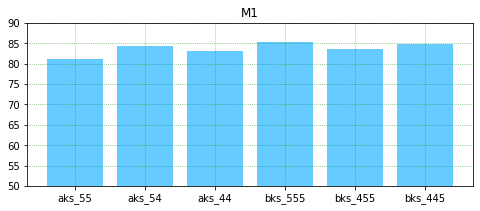

In [28]:
plt.figure(figsize = (8, 3))
plt.title('M1')
plt.bar(np.arange(len(M1_C)), M1_C, color = "#66ccff")
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M1_C)), names_C)
plt.ylim([50, 90])

(50.0, 90.0)

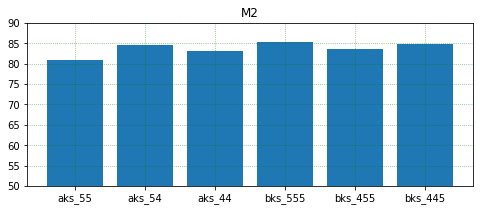

In [29]:
plt.figure(figsize = (8, 3))
plt.title('M2')
plt.bar(np.arange(len(M2_C)), M2_C)
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M2_C)), names_C)
plt.ylim([50, 90])

(50.0, 90.0)

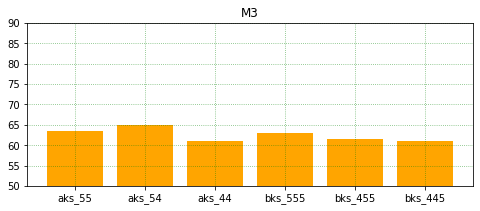

In [30]:
plt.figure(figsize = (8, 3))
plt.title('M3')
plt.bar(np.arange(len(M3_C)), M3_C, color = "orange")
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M3_C)), names_C)
plt.ylim([50, 90])

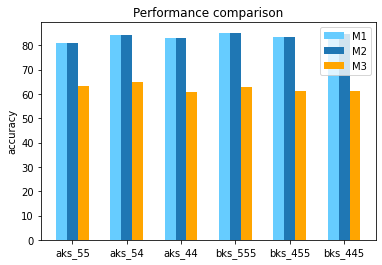

In [31]:
x = np.arange(len(names_C))  # the label locations
width = 0.2                # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width, M1_C, width, label='M1', color="#66ccff")
rects2 = ax.bar(x, M2_C, width, label='M2')
rects3 = ax.bar(x + width, M3_C, width, label='M3', color="orange")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('accuracy')
ax.set_title('Performance comparison')
ax.set_xticks(x)
ax.set_xticklabels(names_C)
ax.legend()

(80.0, 200.0)

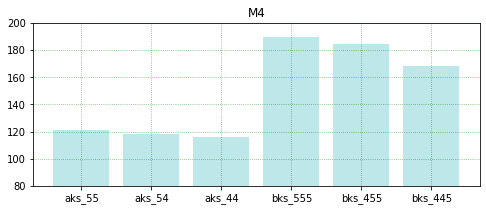

In [33]:
plt.figure(figsize = (8, 3))
plt.title('M4')
plt.bar(np.arange(len(M4_C)), M4_C, color = "#BEE7E9")
plt.grid(True, linestyle=':', color='g', alpha=0.6)
plt.xticks(np.arange(len(M4_C)), names_C)
plt.ylim([80, 200])

In [ ]:
print("# ------ My answer of c3b ------ #")

For C2a CNN with 2 Convs and 2 FC layers:
* I set 2 different `kernel_size` for 2 Convs, e.g. ks1 = (5, 5) (5, 5), ks2 = (5, 5) (4, 4), ks3 = (4, 4) (4, 4).
* To my surprise, a kernel_size of (4, 4) (4, 4) performs better on the test set than a kernel_size of (5, 5) (5, 5).
* To my surprise, the training time required for a kernel_size of (4, 4) (4, 4) is longer than for a kernel_size of (5, 5) (5, 5).

For C2b CNN with 3 Convs and 3 FC layers:
* I set 3 different `kernel_size` for 3 Convs, e.g. ks1 = (5, 5) (5, 5) (5, 5), ks2 = (4, 4) (5, 5) (5, 5), ks3 = (4, 4) (4, 4) (5, 5).
* However, the accuracy of both c2b and c2a is similar in M1 M2 M3. The increase in the number of Convs in this question is not a big improvement in terms of accuracy. Instead the running time of C2b is much longer (1 minute longer).

## D. Unsupervised learning on Fashion-MNIST [8 marks]

Fashion-MNIST is a dataset of Zalando's article images, with examples shown above. It consists of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes: 0=T-shirt/top; 1=Trouser; 2=Pullover; 3=Dress; 4=Coat; 5=Sandal; 6=Shirt; 7=Sneaker; 8=Bag; 9=Ankle boot.

Choose any two out of the 10 classes and use only the test data for these two chosen classes to complete tasks in this section. It will be better to finish reading the remaining part of this section before choosing the two classes. Again, you may choose any two and there is no “correct” answer about which two to choose but some choices may make your studies below more interesting than others.

Use the PyTorch API for Fashion-MNIST to load the training/test data of Fashion-MNIST. You may refer to similar procedures in Lab 7 for CIFAR-10.

In [4]:
# Load the data
batchSize = 64

transform = transforms.Compose([transforms.ToTensor(), 
                                transforms.Normalize([.5], [.5])])
# Training data
trainset_D = datasets.FashionMNIST(root='./data', train=True,
                                   download=True, transform=transform)

trainloader_D = DataLoader(trainset_D, batch_size=batchSize,
                           shuffle=True, num_workers=2)
# Test data
testset_D = datasets.FashionMNIST(root='./data', train=False,
                                  download=True, transform=transform)

testloader_D = DataLoader(testset_D, batch_size=batchSize, 
                          shuffle=False, num_workers=2)

classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')
print('Training set size:', len(trainset_D))
print('Test set size:', len(testset_D))

Training set size: 60000
Test set size: 10000


### D1. Dimensionality reduction and clustering [7 marks]

**a.** Apply PCA to all images of these two chosen classes. Visualise the top 5 eigenvectors as images and display them in the order of descending corresponding values (the one corresponding to the largest eigenvalue first). **[1 marks]**

**b.** Use the top 30 PCs to reconstruct 10 images, with 5 from each class (any 5 images are fine from each class). Show these 10 pairs of reconstructed and original images. **[1 marks]**
    
**c.** Visualise the two-dimensional PCA representations of all data points in a 2D plane (i.e. using the top two PCs). Use different colours/markers for the two classes for better visualisation (Hint: You need to use the class labels here for visualisation). **[1 marks]**

**d.** Use spectral clustering to cluster all data points as represented by the top two PCs (clustering of two-dimensional vectors, where each vector has two values, PC1 and PC2). Visualise the two clusters with different colours/markers in 2D. **[2 marks]**

**e.** Design a new autoencoder with five Conv2d layers and five ConvTranspose2d layers. You are free to choose the activation functions and settings such as stride and padding. Train this new autoencoder on all images of these two chosen classes for at least 20 epochs. Plot the loss against the epoch. **[2 marks]**

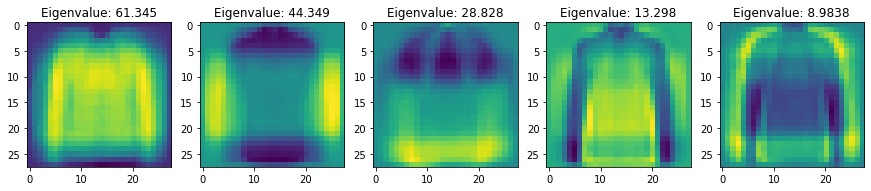

In [304]:
# ------ My answer of D1a ------ #
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
input_dim = 784                  # 28*28
chosen_imgs = []
label = []


for i in testset_D:
    if (i[1] == 6) or (i[1] == 8):
        chosen_imgs.append(i[0])
        label.append(i[1])

X = torch.stack(chosen_imgs).view(-1, input_dim)

pca = PCA(n_components = 5) # Top 5 eigenvectors
pca.fit(X)
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_.reshape((5, 28, 28))


plt.figure(figsize=(15, 15))
for i, eigenvector in enumerate(eigenvectors):
    plt.subplot(1, 5, i + 1)
    plt.title(f"Eigenvalue: {eigenvalues[i]:.5}")
    plt.imshow(eigenvector)

Here are the 10 pairs of original and reconstructed images: (original fist)


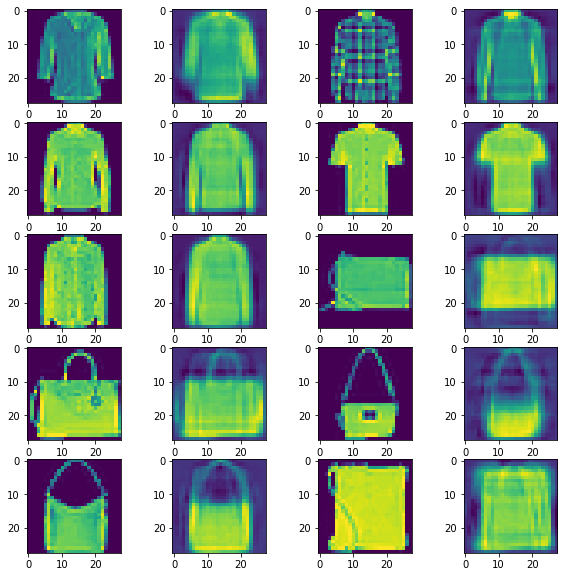

In [305]:
# ------ My answer of D1b ------ #
the_class_0 = [i for i, x in enumerate(label) if x == 6]
the_class_1 = [i for i, x in enumerate(label) if x == 8]

x = []
x.append(X[the_class_0[:5]])
x.append(X[the_class_1[:5]])

# print(x[0].shape) # torch.Size([5, 784])
# print(x[1].shape) # torch.Size([5, 784])

pca = PCA(n_components = 30) # Top 30 eigenvectors
pca.fit(X)

pca_tras_0 = pca.transform(X[the_class_0[:5]])
pca_tras_1 = pca.transform(X[the_class_1[:5]])

reconstr_0 = pca.inverse_transform(pca_tras_0)
reconstr_1 = pca.inverse_transform(pca_tras_1)

show_list = []
for i in range(5):
    show_list.append(X[the_class_0[i]])
    show_list.append(reconstr_0[i])
for i in range(5):
    show_list.append(X[the_class_1[i]])
    show_list.append(reconstr_1[i])

plt.rcParams["figure.figsize"]=10, 10    
for i, image in enumerate(show_list):
    plt.subplot(5, 4, i + 1)
    plt.imshow(image.reshape(28, 28))
    
print("Here are the 10 pairs of original and reconstructed images: (original fist)")

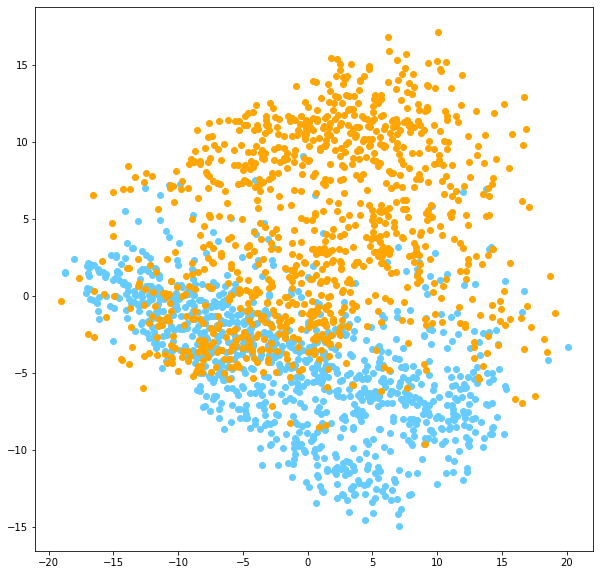

In [306]:
# ------ My answer of D1c ------ #
pca = PCA(n_components = 2) # Top 2 eigenvectors
pca.fit(X)
X_2D = pca.transform(X)
X_2D_0 = X_2D[the_class_0]
X_2D_1 = X_2D[the_class_1]

plt.figure(figsize=(10, 10))
plt.scatter(X_2D_0[:,0], X_2D_0[:,1], c='#66ccff')
plt.scatter(X_2D_1[:,0], X_2D_1[:,1], c='orange')

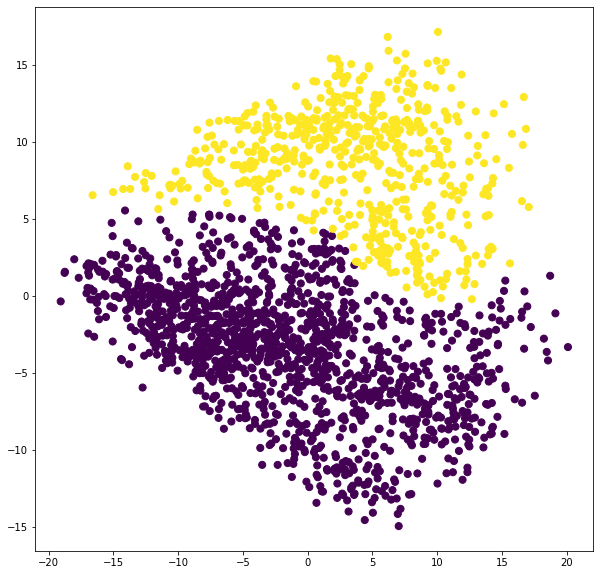

In [307]:
# ------ My answer of D1d ------ #
from sklearn.cluster import SpectralClustering

clustering = SpectralClustering(n_clusters=2, assign_labels='discretize', random_state=210169508)
SClabel = clustering.fit_predict(X_2D)

plt.scatter(X_2D[:,0], X_2D[:, 1], c=SClabel, s=50, cmap='viridis')


# In practice Spectral Clustering is very useful when the structure of 
# the individual clusters is highly non-convex, or more generally 
# when a measure of the center and spread of the cluster is not 
# a suitable description of the complete cluster, such as when 
# clusters are nested circles on the 2D plane.

In [313]:
# ------ My answer of D1e ------ #
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, padding=1, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3),
            nn.ReLU(),
            nn.Conv2d(128, 256, 5, padding=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 5, padding=2),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 3, padding=1, stride=2, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, padding=1, stride=2, output_padding=1),
            nn.Sigmoid()  
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


batch_size = 64
max_epochs = 20
lr_D = 0.0001
epochs = []
losses = []

myAE = Autoencoder()
criterion = nn.MSELoss() # Choose mean square error loss
optimizer = torch.optim.Adam(myAE.parameters(), lr=lr_D, weight_decay=1e-5) # Choose the Adam optimiser


chosen_idxs = (testset_D.targets == 6) | (testset_D.targets == 8) # Use the two chosen classes in the test set
chosen_idxs = np.where(chosen_idxs.numpy())[0]
new_dataset = torch.utils.data.Subset(testset_D, chosen_idxs)

testloader_D = DataLoader(new_dataset, batch_size=batchSize, shuffle=True)


for epoch in range(max_epochs):
    for data in testloader_D:
        img, label = data
        optimizer.zero_grad()
        recon = myAE(img)
        loss = criterion(recon, img)
        loss.backward()
        optimizer.step()            

    print('Epoch:{}, Loss:{:.5f}'.format(epoch + 1, float(loss)))
    epochs.append(epoch + 1)
    losses.append(float(loss))


Epoch:1, Loss:1.12213
Epoch:2, Loss:0.67430
Epoch:3, Loss:0.62808
Epoch:4, Loss:0.57940
Epoch:5, Loss:0.57536
Epoch:6, Loss:0.55927
Epoch:7, Loss:0.61818
Epoch:8, Loss:0.65783
Epoch:9, Loss:0.59645
Epoch:10, Loss:0.58888
Epoch:11, Loss:0.66054
Epoch:12, Loss:0.54982
Epoch:13, Loss:0.58658
Epoch:14, Loss:0.61432
Epoch:15, Loss:0.62833
Epoch:16, Loss:0.59613
Epoch:17, Loss:0.62842
Epoch:18, Loss:0.58796
Epoch:19, Loss:0.54985
Epoch:20, Loss:0.58764


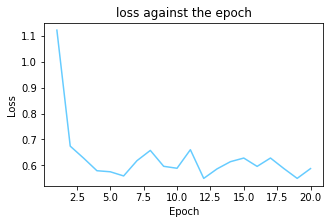

In [314]:
plt.figure(figsize=(5, 3))
plt.title('loss against the epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(epochs, losses, '-', color='#66ccff')

### D2 Observation [1 marks]

Describe at least two observations interesting to you from D1 above.

## The END of Assignment

---